In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from shapely.geometry import box
import openpyxl

/var/folders/0n/296qsft52w53ggpnw204hrxw0000gq/T/ipykernel_67588/802366073.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/0n/296qsft52w53ggpnw204hrxw0000gq/T/ipykernel_67588/802366073.py:61: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


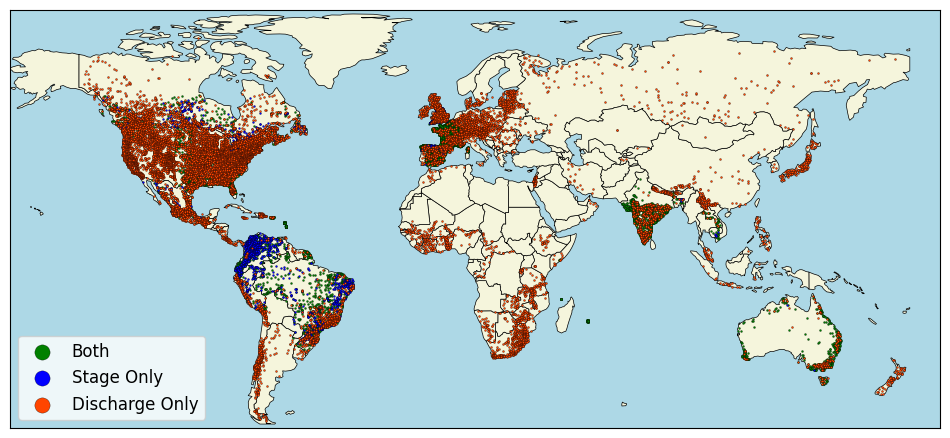

In [27]:
df = pd.read_csv('/Users/yubinbaaniya/Downloads/final_modified_gauge_review.csv')

# Load the Natural Earth Low-Resolution dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Patterson projection setup
wgs84 = Proj(proj='latlong', datum='WGS84')
patterson = Proj(proj='patterson', lon_0=12)
transformer = Transformer.from_proj(wgs84, patterson)

# Transform station coordinates to Patterson projection
df['x'], df['y'] = transformer.transform(df['longitude'], df['latitude'])

# Clip Antarctica from the Natural Earth dataset
antarctica_box = box(-168, -55, 180, 90)
bbox_antarctica = gpd.GeoDataFrame(geometry=[antarctica_box], crs='EPSG:4326')
bbox_antarctica = bbox_antarctica.to_crs(world.crs)
world = gpd.clip(world, bbox_antarctica)
world = world.to_crs(patterson.srs)

# Categorize stations based on measurement types
df['category'] = 'Discharge Only'  # Default/Unknown will be treated as Discharge Only
df.loc[(df['MeasuresStage'] == True) & (df['MeasuresDischarge'] == True), 'category'] = 'Both'
df.loc[(df['MeasuresStage'] == True) & (df['MeasuresDischarge'] == False), 'category'] = 'Stage Only'
df.loc[(df['MeasuresStage'] == False) & (df['MeasuresDischarge'] == True), 'category'] = 'Discharge Only'
df.loc[(df['MeasuresStage'] == False) & (df['MeasuresDischarge'] == False), 'category'] = 'Neither'

# Create a color mapping for different categories
color_map = {
    'Both': 'green',
    'Stage Only': 'blue',
    'Discharge Only': 'orangered',
    'Neither': 'gray'
}

# Plot the map
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot the world map
world.plot(ax=ax, color='beige', edgecolor='black', linewidth=0.5)

# Plot stations by category
for category, color in color_map.items():
    subset = df[df['category'] == category]
    if not subset.empty:
        ax.scatter(
            subset['x'], subset['y'], 
            color=color, 
            s=2,
            edgecolor='black', 
            linewidth=0.2, 
            label=f"{category}"
        )


# Add legend with increased font size and marker size
legend = plt.legend(loc='lower left', fontsize=12)

# Increase the size of the markers in the legend
for handle in legend.legendHandles:
    handle.set_sizes([120])

# Map settings
ax.set_xlim([-2e7, 2e7])
ax.set_ylim([-0.7e7, 1.1e7])
ax.set_facecolor('lightblue')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Add title
#plt.title('Station Distribution by Measurement Type', fontsize=12)

# Save the plot (modify the path to your preferred location)
plt.savefig('/Users/yubinbaaniya/Library/CloudStorage/Box-Box/master thesis and what not/Gauge review/station_distribution_by_measurement.png', dpi=1500, bbox_inches='tight')

plt.show()

/var/folders/0n/296qsft52w53ggpnw204hrxw0000gq/T/ipykernel_67588/1269893418.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


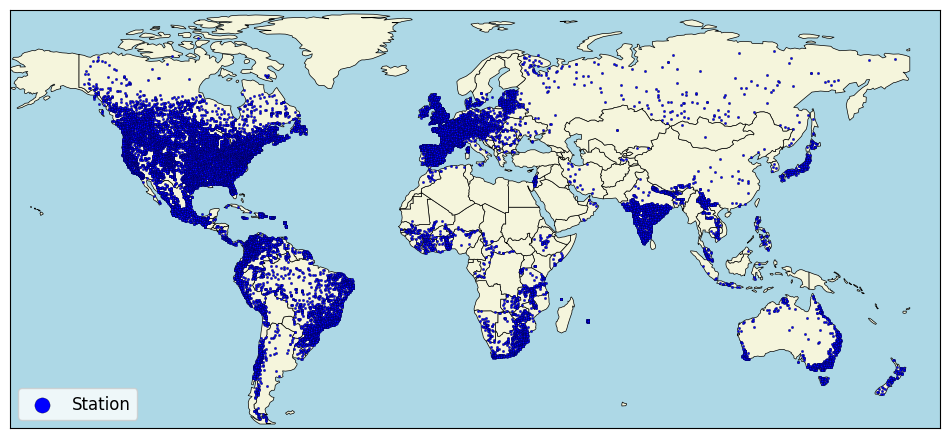

In [26]:
# Plot the map
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot the world map
world.plot(ax=ax, color='beige', edgecolor='black', linewidth=0.5)

# Plot all stations with the same color
ax.scatter(
    df['x'], df['y'], 
    color='blue',  # Single color for all stations
    s=3,  # Size of the markers
    edgecolor='black', 
    linewidth=0.2, 
    label=f"Station"
)

# Add legend with increased font size and marker size
legend = plt.legend(loc='lower left', fontsize=12)

# Increase the size of the markers in the legend
for handle in legend.legendHandles:
    handle.set_sizes([120])

# Map settings
ax.set_xlim([-2e7, 2e7])
ax.set_ylim([-0.7e7, 1.1e7])
ax.set_facecolor('lightblue')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Add title
#plt.title('Station Distribution', fontsize=14)

# Save the plot (modify the path to your preferred location)
plt.savefig('/Users/yubinbaaniya/Library/CloudStorage/Box-Box/master thesis and what not/Gauge review/station_distribution_single_color.png', dpi=1500, bbox_inches='tight')

plt.show()

stacked cumulative plot

<Figure size 1200x600 with 0 Axes>

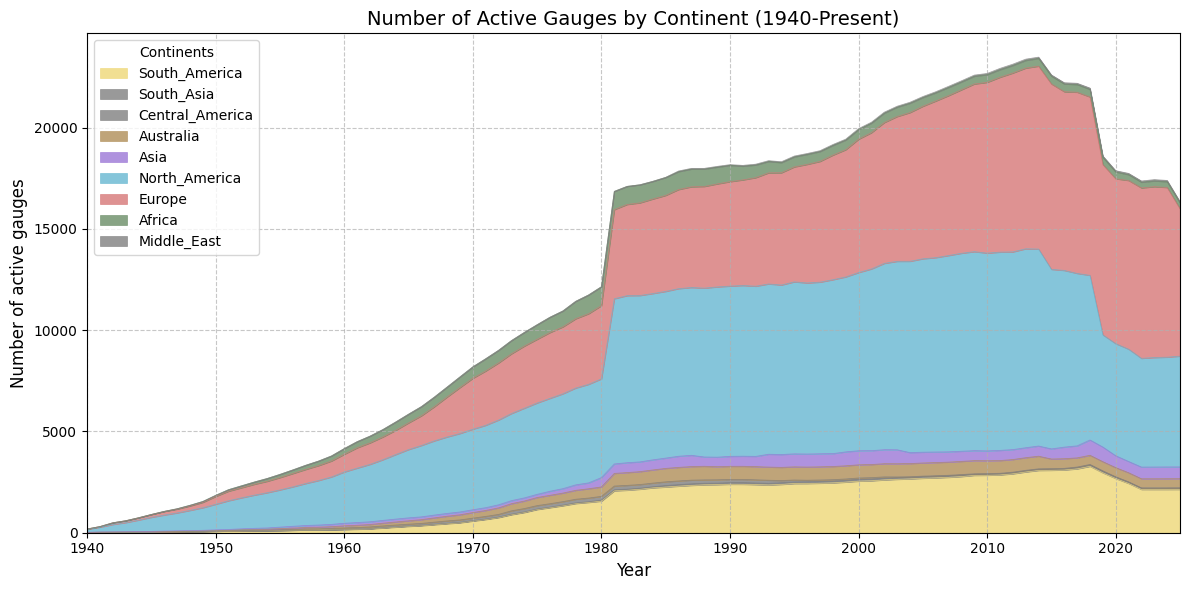

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Load the Excel file
df = pd.read_excel('/Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx')

# Convert date columns to datetime
df['Date of First measurement'] = pd.to_datetime(df['Date of First measurement'], errors='coerce')
df['Date of Last Measurement'] = pd.to_datetime(df['Date of Last Measurement'], errors='coerce')

# Extract years
df['First Year'] = df['Date of First measurement'].dt.year
df['Last Year'] = df['Date of Last Measurement'].dt.year

# Filter to include only gauges starting from 1940
df_filtered = df[df['First Year'] >= 1940].copy()

# Create a year range from 1940 to present
current_year = datetime.now().year
years = range(1940, current_year + 1)

# Function to count active gauges by continent for each year
def count_active_gauges(data, continents, years):
    counts = {}
    for continent in continents:
        continent_counts = []
        for year in years:
            # Count gauges where:
            # 1. First year is less than or equal to current year AND
            # 2. (Last year is greater than or equal to current year OR gauge is still active)
            count = data[(data['Continent'] == continent) & 
                         (data['First Year'] <= year) & 
                         ((data['Last Year'] >= year) | (data['Gauge still active'] == 1))].shape[0]
            continent_counts.append(count)
        counts[continent] = continent_counts
    return counts

# Get unique continents (excluding null values)
continents = df_filtered['Continent'].dropna().unique()

# Count active gauges by continent for each year
counts = count_active_gauges(df_filtered, continents, years)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({continent: counts[continent] for continent in continents}, index=years)

# Set color map for continents
continent_colors = {
    'North_America': '#67B7D1',  # Light blue
    'Europe': '#D67777',         # Pink/Red
    'Australia': '#B08D57',      # Brown
    'South_America': '#EED777',  # Yellow
    'Asia': '#9B77D6',           # Purple
    'Africa': '#6B8E67',         # Green
    # Add colors for other continents as needed
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot stacked area chart
ax = plot_df.plot.area(
    figsize=(12, 6),
    color=[continent_colors.get(c, 'gray') for c in plot_df.columns],
    alpha=0.8,
    stacked=True,
    linewidth=0.5
)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Number of Active Gauges by Continent (1940-Present)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of active gauges', fontsize=12)
plt.xlim(1940, current_year)
plt.ylim(0, None)

# Add legend
plt.legend(title='Continents', loc='upper left')

# Improve x-axis tick labels
plt.xticks(np.arange(1940, current_year+1, 10))

# Save the figure
plt.tight_layout()
#plt.savefig('active_gauges_by_continent.png', dpi=300)

# Show the plot
plt.show()

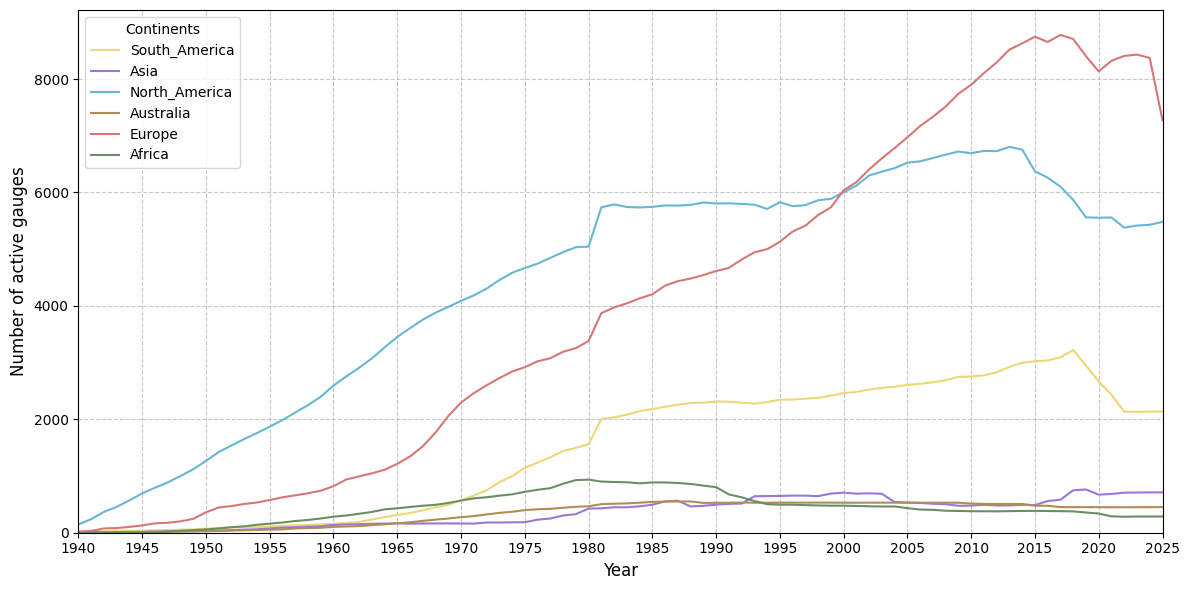

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the Excel file
df = pd.read_excel('/Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx')
df = df[df['primary_gauge'].isna() | (df['main gauge'] == 1)]

# Convert date columns to datetime
df['Date of First measurement'] = pd.to_datetime(df['Date of First measurement'], errors='coerce')
df['Date of Last Measurement'] = pd.to_datetime(df['Date of Last Measurement'], errors='coerce')

# Extract years
df['First Year'] = df['Date of First measurement'].dt.year
df['Last Year'] = df['Date of Last Measurement'].dt.year

# Filter to include only gauges starting from 1940
df_filtered = df[df['First Year'] >= 1940].copy()

# Create a consolidated Continent column with the requested groupings
df_filtered['Consolidated_Continent'] = df_filtered['Continent'].copy()

# Map regions to be combined
region_mapping = {
    'Central_America': 'North_America',  # Combine Central America with North America
    'Middle_East': 'Asia',               # Combine Middle East with Asia
    'South_Asia': 'Asia'                 # Combine South Asia with Asia
}

# Apply the mapping
df_filtered['Consolidated_Continent'] = df_filtered['Consolidated_Continent'].replace(region_mapping)

# Create a year range from 1940 to present
current_year = datetime.now().year
years = range(1940, current_year + 1)

# Function to count active gauges by consolidated continent for each year
def count_active_gauges(data, continents, years):
    counts = {}
    for continent in continents:
        continent_counts = []
        for year in years:
            # Count gauges where:
            # 1. First year is less than or equal to current year AND
            # 2. (Last year is greater than or equal to current year OR gauge is still active)
            count = data[(data['Consolidated_Continent'] == continent) & 
                         (data['First Year'] <= year) & 
                         ((data['Last Year'] >= year) | (data['Gauge still active'] == 1))].shape[0]
            continent_counts.append(count)
        counts[continent] = continent_counts
    return counts

# Get unique consolidated continents (excluding null values)
consolidated_continents = df_filtered['Consolidated_Continent'].dropna().unique()

# Count active gauges by consolidated continent for each year
counts = count_active_gauges(df_filtered, consolidated_continents, years)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({continent: counts[continent] for continent in consolidated_continents}, index=years)

# Set color map for continents
continent_colors = {
    'North_America': '#67B7D1',  # Light blue
    'Europe': '#D67777',         # Pink/Red
    'Australia': '#B08D57',      # Brown
    'South_America': '#EED777',  # Yellow
    'Asia': '#9B77D6',           # Purple
    'Africa': '#6B8E67',         # Green
    # Add colors for other continents as needed
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot individual lines for each continent
for continent in plot_df.columns:
    plt.plot(plot_df.index, plot_df[continent], 
             label=continent, 
             color=continent_colors.get(continent, 'gray'),
             linewidth=1.5)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
#plt.title('Number of Active Gauges by Continent (1940-Present)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of active gauges', fontsize=12)
plt.xlim(1940, current_year)
plt.ylim(0, None)

# Add legend
plt.legend(title='Continents', loc='upper left')

# Improve x-axis tick labels
plt.xticks(np.arange(1940, current_year+1, 5))

# Save the figure
plt.tight_layout()
#plt.savefig('active_gauges_by_consolidated_continent_trendlines.png', dpi=300)

# Show the plot
plt.show()

Number of stations by measurement duration:
<1 year: 923
1-5 years: 3956
5-10 years: 3234
10-20 years: 5753
20-30 years: 5478
30-50 years: 10289
50-100 years: 7212
>100 years: 610


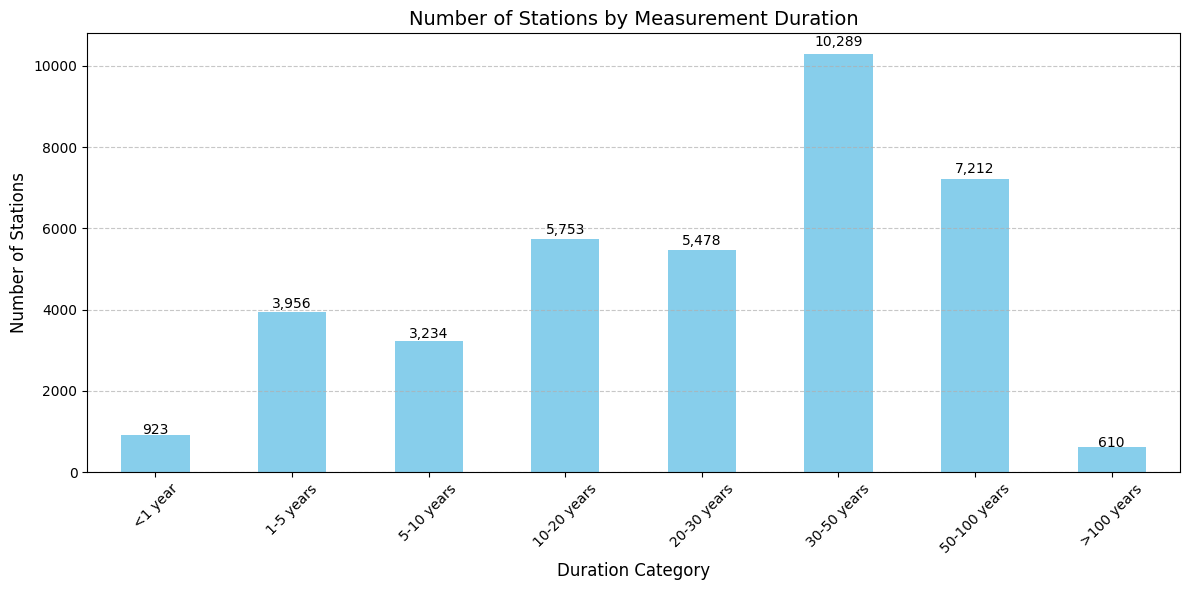

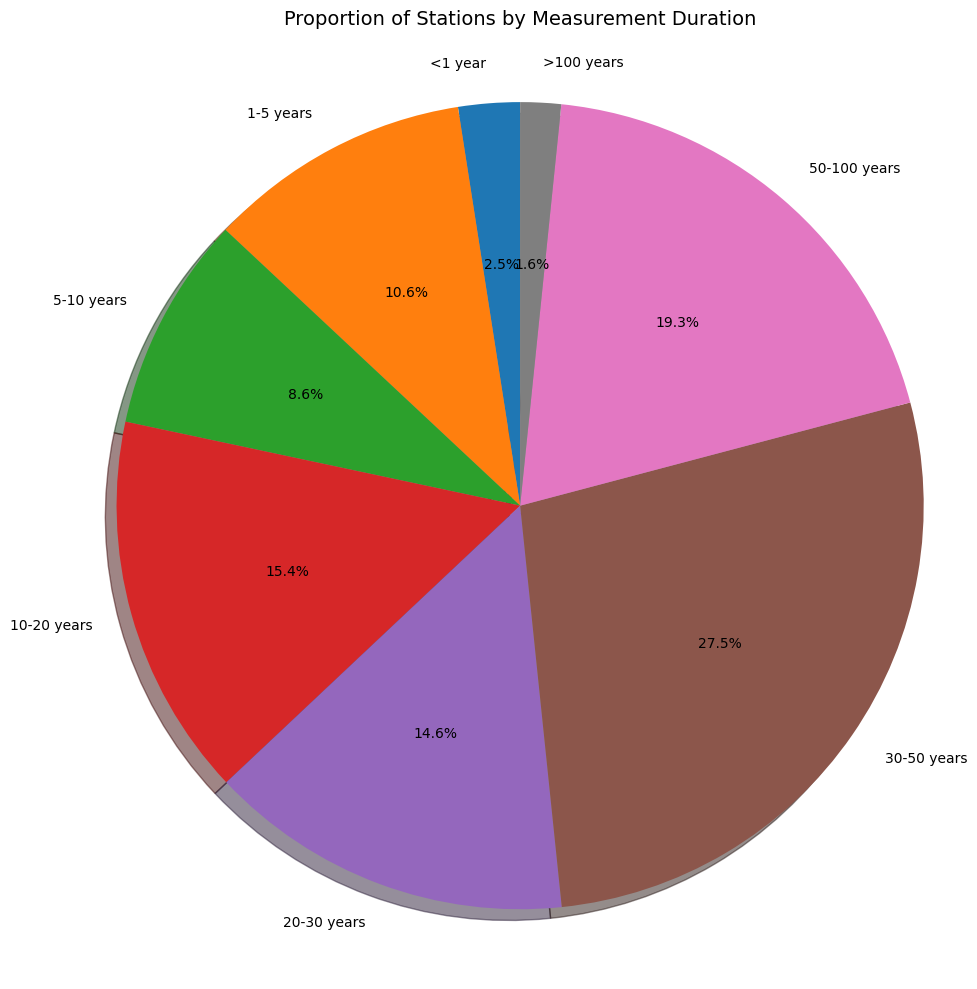


Breakdown by consolidated continent and duration category:
Duration_Category       <1 year  1-5 years  5-10 years  10-20 years  \
Consolidated_Continent                                                
Africa                        1        169         113          199   
Asia                        459        608         139          341   
Australia                     0         25           9           14   
Europe                      329       1351        1341         2284   
North_America               106        998        1050         2283   
South_America                28        805         582          632   
Total                       923       3956        3234         5753   

Duration_Category       20-30 years  30-50 years  50-100 years  >100 years  \
Consolidated_Continent                                                       
Africa                          229          292           187           8   
Asia                            197          431           131    

<Figure size 1400x800 with 0 Axes>

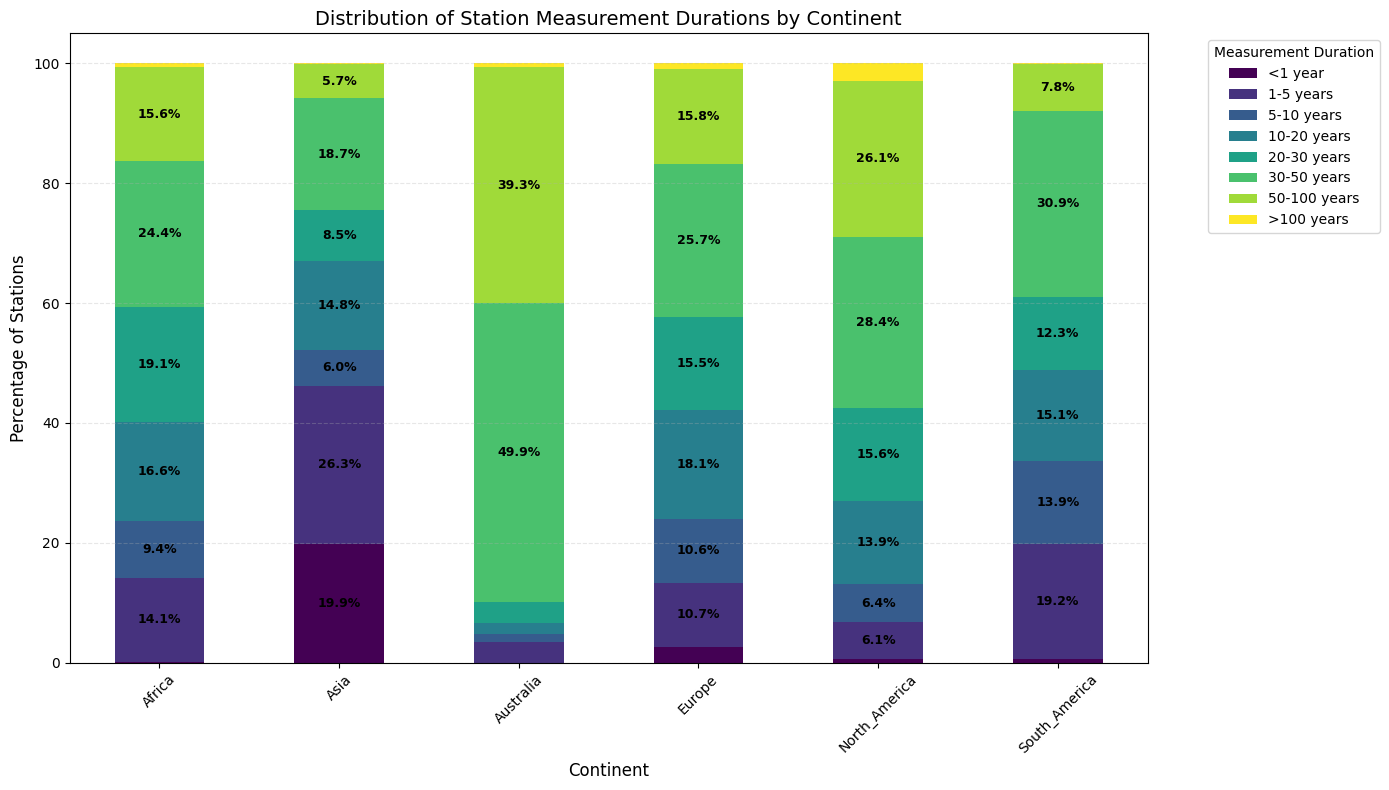


Number of stations by consolidated continent:
Consolidated_Continent
North_America    16430
Europe           12605
South_America     4195
Asia              2327
Africa            1265
Australia          718
Name: count, dtype: int64


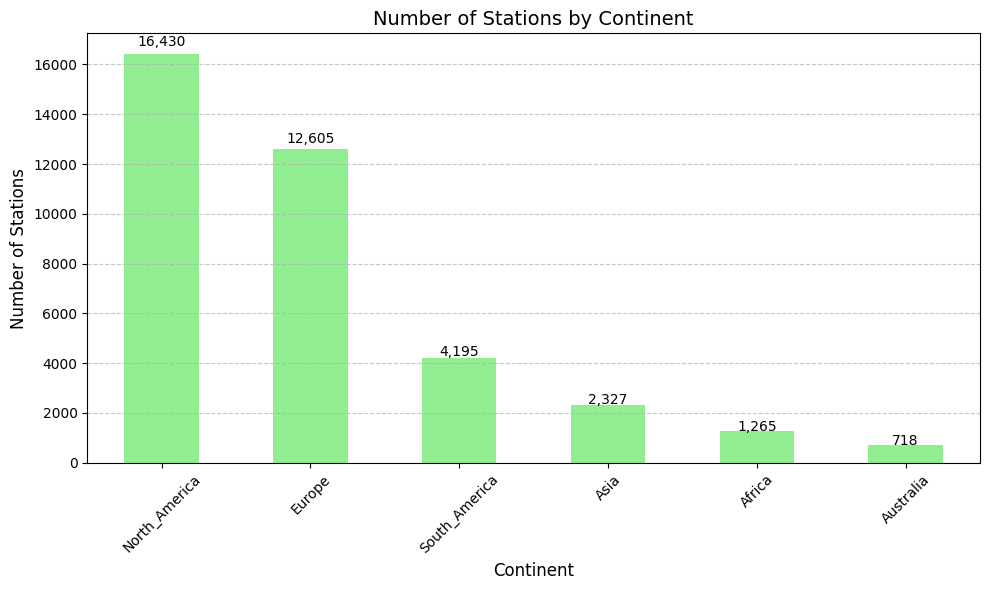

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel('/Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx')

# Convert number of daily measurements to years (assuming 365 days per year)
df['Measurement_Years'] = df['Number of daily measurements'] / 365

# Create a consolidated Continent column
df['Consolidated_Continent'] = df['Continent'].copy()

# Map regions to be combined
region_mapping = {
    'Central_America': 'North_America',  # Combine Central America with North America
    'Middle_East': 'Asia',               # Combine Middle East with Asia
    'South_Asia': 'Asia'                 # Combine South Asia with Asia
}

# Apply the mapping
df['Consolidated_Continent'] = df['Consolidated_Continent'].replace(region_mapping)

# Define the categories
categories = [
    '<1 year', 
    '1-5 years', 
    '5-10 years', 
    '10-20 years', 
    '20-30 years', 
    '30-50 years', 
    '50-100 years', 
    '>100 years'
]

# Define the bin edges for categorization
bin_edges = [0, 1, 5, 10, 20, 30, 50, 100, float('inf')]

# Create a new column with the categorized values
df['Duration_Category'] = pd.cut(
    df['Measurement_Years'], 
    bins=bin_edges, 
    labels=categories,
    right=False  # Ensures that the intervals are [a, b) rather than (a, b]
)

# Count the number of stations in each category
category_counts = df['Duration_Category'].value_counts().reindex(categories)

print("Number of stations by measurement duration:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Create a bar chart to visualize the distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Stations by Measurement Duration', fontsize=14)
plt.xlabel('Duration Category', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(category_counts):
    plt.text(i, count + (count * 0.02), f"{count:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('station_duration_categories.png', dpi=300)
plt.show()

# Optional: Create a pie chart to show the proportion of each category
plt.figure(figsize=(10, 10))
plt.pie(
    category_counts, 
    labels=category_counts.index, 
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)
plt.axis('equal')
plt.title('Proportion of Stations by Measurement Duration', fontsize=14)
plt.tight_layout()
plt.savefig('station_duration_pie.png', dpi=300)
plt.show()

# Display breakdown by CONSOLIDATED continent
print("\nBreakdown by consolidated continent and duration category:")
continent_duration = pd.crosstab(
    df['Consolidated_Continent'], 
    df['Duration_Category'],
    margins=True,
    margins_name='Total'
)
print(continent_duration)

# Create a stacked bar chart showing the duration distribution by continent
plt.figure(figsize=(14, 8))

# Get continents (excluding the 'All' row from crosstab)
continents = [c for c in continent_duration.index if c != 'Total']

# Create a stacked bar chart
continent_duration_pct = continent_duration.loc[continents].div(
    continent_duration.loc[continents, 'Total'], axis=0
).drop('Total', axis=1) * 100

continent_duration_pct.plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 8),
    colormap='viridis'
)

plt.title('Distribution of Station Measurement Durations by Continent', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Percentage of Stations', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Measurement Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add percentage labels on the bars
for continent_idx, continent in enumerate(continents):
    cumulative_sum = 0
    for category_idx, category in enumerate(continent_duration_pct.columns):
        value = continent_duration_pct.loc[continent, category]
        if value > 5:  # Only show labels for segments > 5%
            plt.text(
                continent_idx,  # x position
                cumulative_sum + value/2,  # y position (middle of segment)
                f"{value:.1f}%",  # text
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold'
            )
        cumulative_sum += value

plt.tight_layout()
#plt.savefig('continent_duration_distribution.png', dpi=300)
plt.show()

# Optionally save the cross-tabulation
continent_duration.to_excel('continent_duration_breakdown.xlsx')

# Also save the percentage breakdown
continent_duration_pct.to_excel('continent_duration_percentage.xlsx')

# Additional analysis: Count of stations by consolidated continent
continent_counts = df['Consolidated_Continent'].value_counts()
print("\nNumber of stations by consolidated continent:")
print(continent_counts)

# Create a bar chart for continent counts
plt.figure(figsize=(10, 6))
continent_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Stations by Continent', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(continent_counts):
    plt.text(i, count + (count * 0.02), f"{count:,}", ha='center', fontsize=10)

plt.tight_layout()
#plt.savefig('station_counts_by_continent.png', dpi=300)
plt.show()

watershed area covered by our gauge

/var/folders/0n/296qsft52w53ggpnw204hrxw0000gq/T/ipykernel_67443/679970002.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


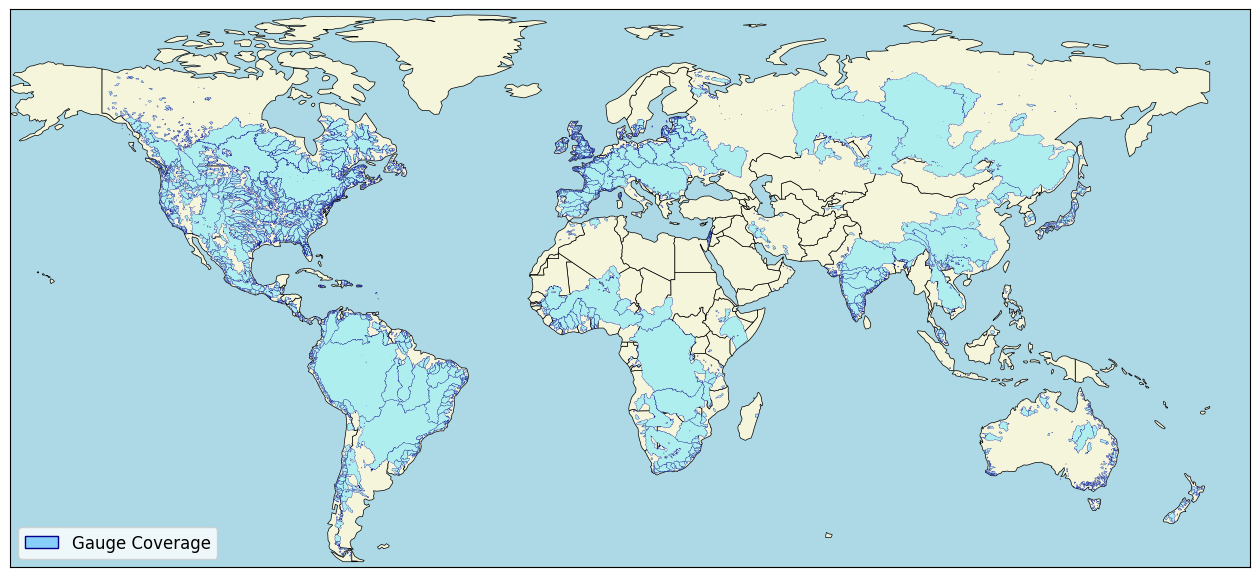

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from shapely.geometry import box
from matplotlib.patches import Patch

# Load the GeoPackage file - replace with your actual file path
gdf = gpd.read_file('/Users/yubinbaaniya/Downloads/combined_all_VPU.gpkg')

# Load the Natural Earth Low-Resolution dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Patterson projection setup
wgs84 = Proj(proj='latlong', datum='WGS84')
patterson = Proj(proj='patterson', lon_0=12)
transformer = Transformer.from_proj(wgs84, patterson)

# Clip Antarctica from the Natural Earth dataset
antarctica_box = box(-168, -55, 180, 90)
bbox_antarctica = gpd.GeoDataFrame(geometry=[antarctica_box], crs='EPSG:4326')
bbox_antarctica = bbox_antarctica.to_crs(world.crs)
world = gpd.clip(world, bbox_antarctica)
world = world.to_crs(patterson.srs)

# Ensure the GeoPackage data is in the same CRS as the world map
if gdf.crs != world.crs:
    gdf = gdf.to_crs(patterson.srs)

# Plot the map
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Plot the world map first
world.plot(ax=ax, color='beige', edgecolor='black', linewidth=0.5)

# Plot the polygon data with complete opacity (alpha=1.0)
gdf.plot(
    ax=ax,
    color='paleturquoise',
    edgecolor='darkblue', 
    linewidth=0.1,
    alpha=1.0,
)

# Manually create a legend element
legend_elements = [Patch(facecolor='lightskyblue', edgecolor='darkblue', label='Gauge Coverage')]
legend = plt.legend(handles=legend_elements, loc='lower left', fontsize=12)

# Map settings
ax.set_xlim([-2e7, 2e7])
ax.set_ylim([-0.7e7, 1.1e7])
ax.set_facecolor('lightblue')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Save the plot (modify the path to your preferred location)
#plt.savefig('/Users/yubinbaaniya/Library/CloudStorage/Box-Box/master thesis and what not/Gauge review/Plot/world_Catchment_coverage.png', dpi=1800, bbox_inches='tight')

plt.show()

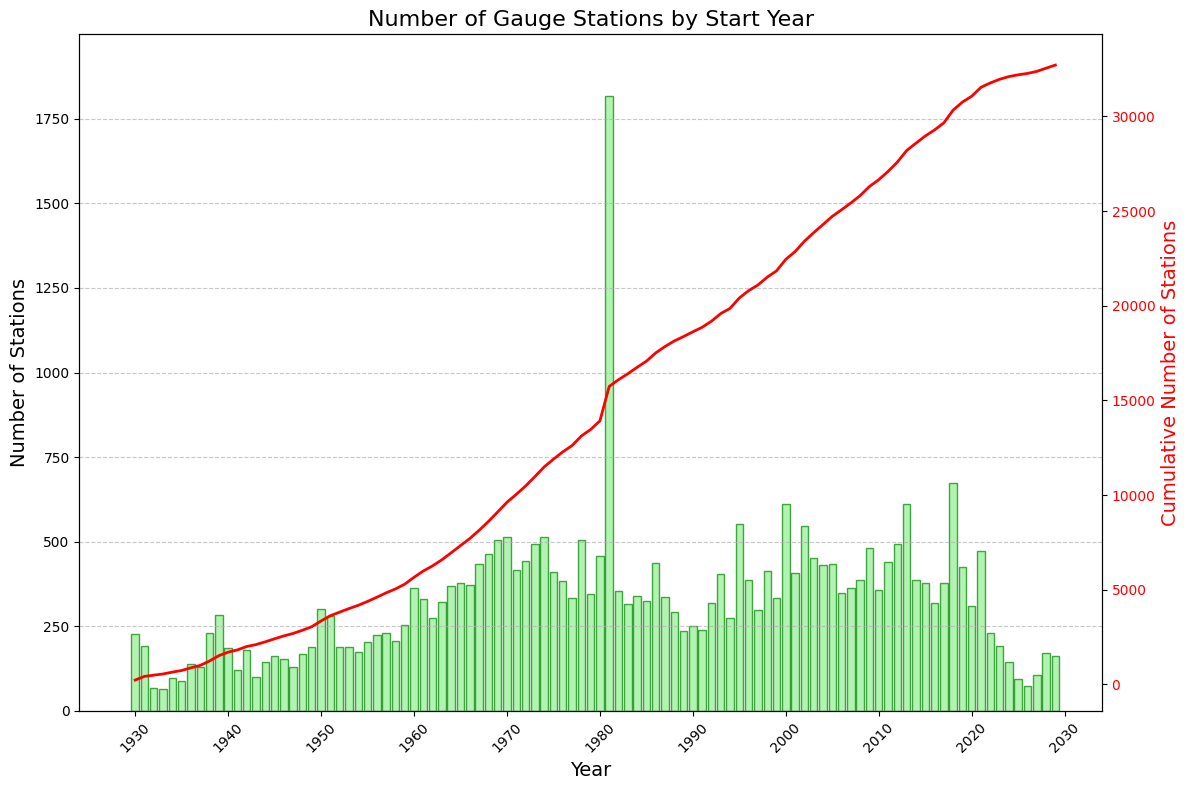

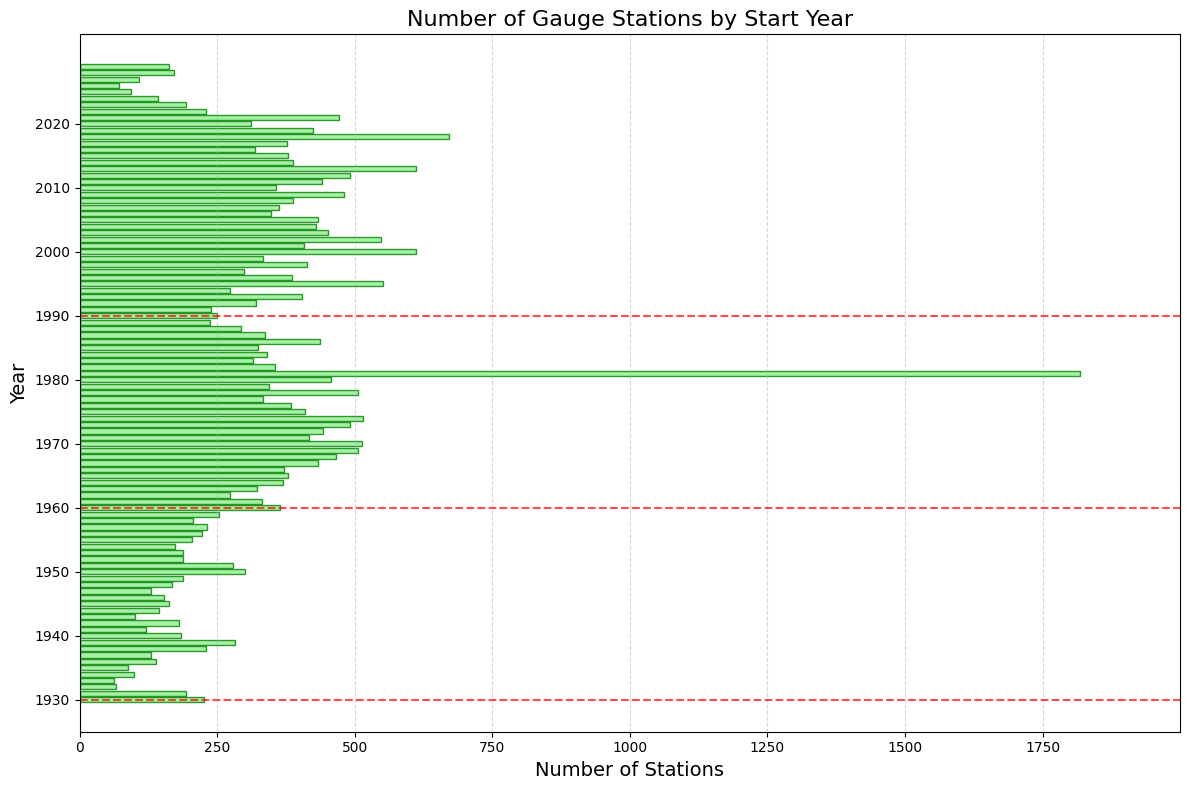

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Load your Excel file
# Replace 'your_file.xlsx' with your actual file name
df = pd.read_excel('/Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx', engine='openpyxl')
df = df[(df['duplicated'] == False) | ((df['duplicated'] == True) & (df['main gauge'] == 1))]

# Convert 'Date of First measurement' to datetime format
# If the format is different, you may need to adjust the parsing
df['Date of First measurement'] = pd.to_datetime(df['Date of First measurement'], errors='coerce')

# Extract the year from the first measurement date
df['Start Year'] = df['Date of First measurement'].dt.year

# Group years before 1930 into a single bin labeled as "Pre-1930"
df['Binned Year'] = df['Start Year'].apply(lambda x: 1930 if x < 1930 else x)

# Count the number of gauges starting in each binned year
yearly_counts = df['Binned Year'].value_counts().sort_index()

# Convert to DataFrame for easier manipulation
yearly_df = pd.DataFrame({'Year': yearly_counts.index, 'Count': yearly_counts.values})

# Calculate cumulative counts
yearly_df['Cumulative'] = yearly_df['Count'].cumsum()

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the number of stations starting in each year
years = yearly_df['Year']
counts = yearly_df['Count']

# Create the histogram
plt.bar(years, counts, color='lightgreen', edgecolor = 'green' ,alpha=0.7)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add titles and labels
plt.title('Number of Gauge Stations by Start Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)

# Format x-axis to show years with appropriate intervals
plt.xlim(1924, max(years) + 5)
ticks = [1930]
ticks.extend(list(range(1940, int(max(years)) + 10, 10)))
plt.xticks(ticks, rotation=45)

# Add some padding to y-axis
plt.ylim(0, max(counts) * 1.1)

# Cumulative line chart (optional, if you want to show cumulative stations)
ax2 = plt.twinx()
ax2.plot(years, yearly_df['Cumulative'], color='red', linewidth=2)
ax2.set_ylabel('Cumulative Number of Stations', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
#plt.savefig('gauge_stations_histogram.png', dpi=300)
plt.show()

# # To recreate something closer to the original chart in your image:
# # The visualization in your image appears to be a "spindle diagram" or specialized histogram
# # Let's create something similar

# plt.figure(figsize=(12, 10))

# # Sort the data by year
# yearly_df = yearly_df.sort_values('Year')

# # Create a horizontal bar chart with years on y-axis
# plt.barh(yearly_df['Year'], yearly_df['Count'], color='lightgreen', edgecolor='green', alpha=0.8)

# # Add red dashed horizontal lines like in your image (at 1930, 1960, 1990)
# plt.axhline(y=1930, color='red', linestyle='--', alpha=0.7)
# plt.axhline(y=1960, color='red', linestyle='--', alpha=0.7)
# plt.axhline(y=1990, color='red', linestyle='--', alpha=0.7)

# # Add labels and title
# plt.xlabel('Number of Stations', fontsize=14)
# plt.ylabel('Year', fontsize=14)
# plt.title('Number of Gauge Stations by Start Year', fontsize=16)

# # Format y-axis to show decades starting from 1930
# end_year = max(yearly_df['Year'])
# plt.yticks(np.arange(1930, (end_year // 10 + 1) * 10, 10))
# plt.ylim(1925, end_year + 5)

# # Add a text label in the middle like the original
# mid_x = yearly_df['Count'].max() / 2
# mid_y = (start_year + end_year) / 2
# #plt.text(mid_x, mid_y, 'daily data', fontsize=12, ha='center')

# # Add grid lines
# plt.grid(axis='x', linestyle='--', alpha=0.5)

# plt.tight_layout()
# #plt.savefig('gauge_stations_spindle_diagram.png', dpi=300)
# plt.show()

# # We can also create a version that more precisely matches your example image
# # This will show the actual distribution like in the image

plt.figure(figsize=(12, 8))

# Create yearly bins from 1930 to end years
all_years = np.arange(1930, max(yearly_df['Year']) + 1)
all_counts = []

# For each year, get its count (0 if no stations started that year)
for year in all_years:
    if year in yearly_df['Year'].values:
        count = yearly_df.loc[yearly_df['Year'] == year, 'Count'].iloc[0]
    else:
        count = 0
    all_counts.append(count)

# Create a new DataFrame with all years
complete_df = pd.DataFrame({'Year': all_years, 'Count': all_counts})

# Create the spindle diagram
# For each year, draw horizontal bars centered on y=year
max_count = max(all_counts)
for i, row in complete_df.iterrows():
    year = row['Year']
    count = row['Count']
    if count > 0:
        # Draw from center to right
        plt.barh(year, count, height=0.8, left=0, color='lightgreen', edgecolor='green', alpha=0.8)

# Add red dashed horizontal lines at 1930, 1960, 1990
plt.axhline(y=1930, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=1960, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=1990, color='red', linestyle='--', alpha=0.7)

# Set axes limits
plt.xlim(0, max_count * 1.1)
plt.ylim(1925, max(yearly_df['Year']) + 5)

# Add labels and title
plt.xlabel('Number of Stations', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.title('Number of Gauge Stations by Start Year', fontsize=16)

# Format y-axis to show decades starting from 1930
plt.yticks(np.arange(1930, (max(yearly_df['Year']) // 10 + 1) * 10, 10))

# Add a text label in the middle
#plt.text(max_count / 2, (start_year + end_year) / 2, 'daily data', fontsize=12, ha='center')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig('gauge_stations_distribution.png', dpi=300)
plt.show()


Reading Excel file: /Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx
Successfully read the file. Shape: (37540, 40)
Processed 35917 valid gauges
Plot saved as: gauge_count_by_year.png
Second plot saved as: gauge_count_by_calendar_year.png


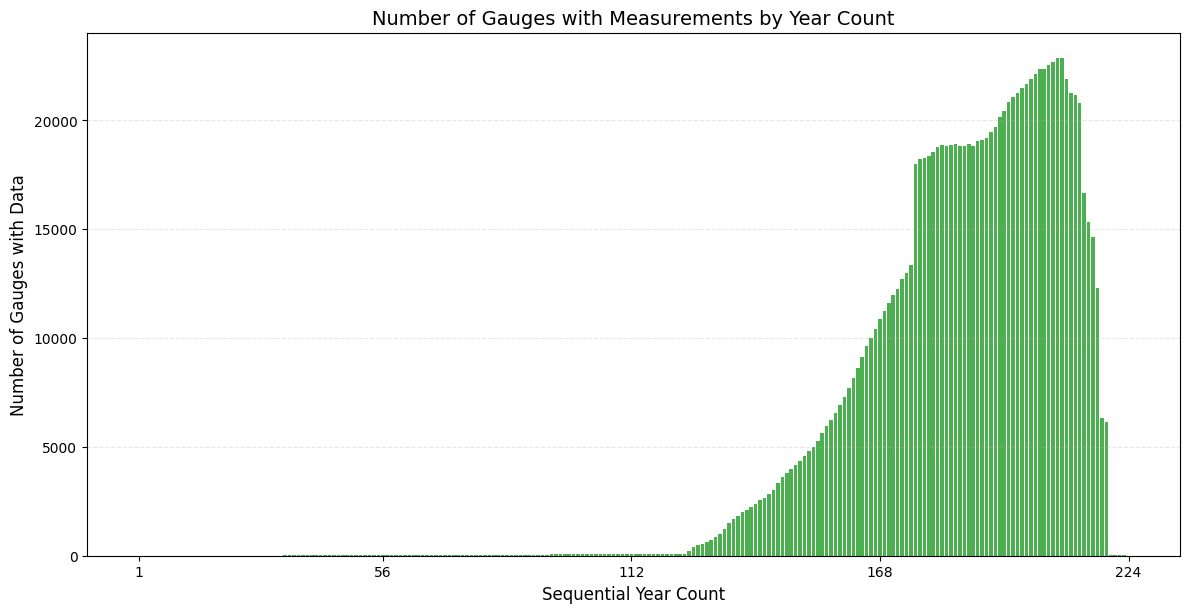

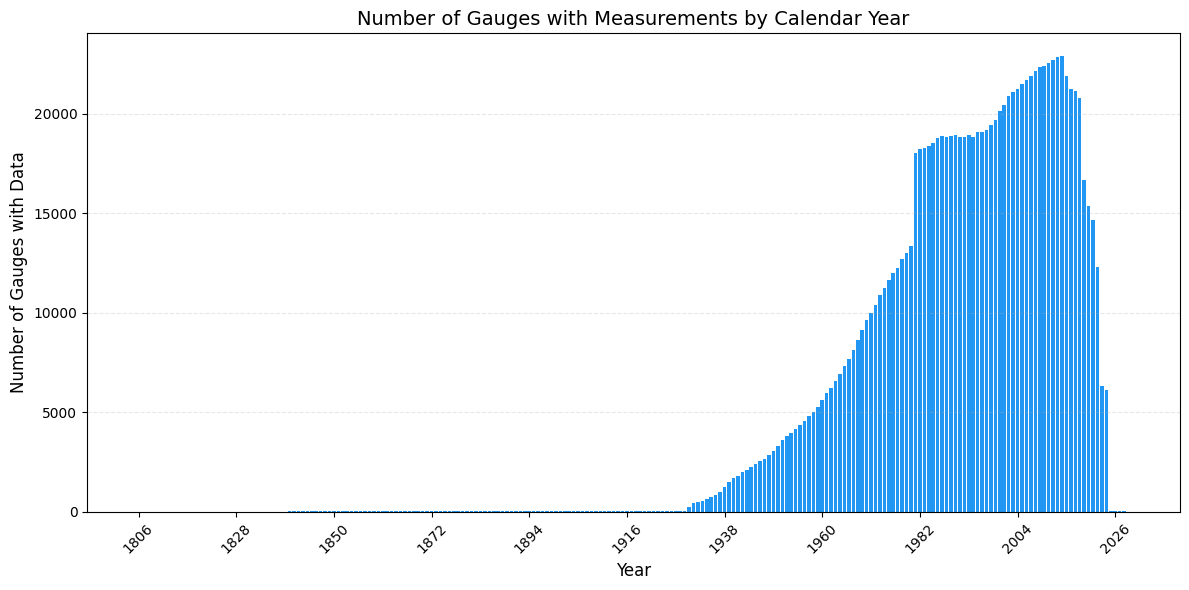

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

# File path - update this to your file location
file_path ='/Users/yubinbaaniya/Downloads/gauge_review_with_duplicate_and_main.xlsx'
print(f"Reading Excel file: {file_path}")

try:
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    print(f"Successfully read the file. Shape: {df.shape}")
    
    # Use the specific column for measurements
    measurement_col = "Number of daily measurements"
    
    # Check if the column exists
    if measurement_col not in df.columns:
        print(f"Column '{measurement_col}' not found in the data")
        exit(1)
    
    # Process the date columns
    first_date_col = "Date of First measurement"
    last_date_col = "Date of Last Measurement"
    
    # Extract years safely
    try:
        df['first_year'] = pd.to_datetime(df[first_date_col], errors='coerce').dt.year
    except:
        try:
            df['first_year'] = df[first_date_col].str.extract(r'(\d{4})').astype(float)
        except:
            df['first_year'] = np.nan
    
    try:
        df['last_year'] = pd.to_datetime(df[last_date_col], errors='coerce').dt.year
    except:
        try:
            df['last_year'] = df[last_date_col].str.extract(r'(\d{4})').astype(float)
        except:
            df['last_year'] = np.nan
    
    # Fill missing values and convert to int
    df['first_year'] = df['first_year'].fillna(0).astype(int)
    df['last_year'] = df['last_year'].fillna(0).astype(int)
    
    # Count how many gauges have data for each year
    year_counts = {}
    valid_gauge_count = 0
    
    for _, row in df.iterrows():
        if row['first_year'] > 0 and row['last_year'] > 0 and row['first_year'] <= row['last_year']:
            valid_gauge_count += 1
            for year in range(row['first_year'], row['last_year'] + 1):
                if year in year_counts:
                    year_counts[year] += 1
                else:
                    year_counts[year] = 1
    
    print(f"Processed {valid_gauge_count} valid gauges")
    
    if not year_counts:
        print("No valid year data found")
        exit(1)
    
    # Sort years and create the data for plotting
    sorted_years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in sorted_years]
    
    # Create a simpler plot with years as sequential numbers
    # This creates an x-axis with just the count of years (1, 2, 3, ...) rather than actual years
    x_values = range(1, len(sorted_years) + 1)
    
    # Create a clean bar plot without text annotations
    plt.figure(figsize=(12, 6))
    plt.bar(x_values, counts, width=0.8, color='#4CAF50')
    
    # Clean up the plot
    plt.xlabel('Sequential Year Count', fontsize=12)
    plt.ylabel('Number of Gauges with Data', fontsize=12)
    plt.title('Number of Gauges with Measurements by Year Count', fontsize=14)
    
    # Remove x-tick labels to avoid clutter
    plt.xticks([])
    
    # Add grid lines only for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Optional: Add a few tick marks at important positions
    num_years = len(sorted_years)
    if num_years > 10:
        tick_positions = [1, num_years // 4, num_years // 2, 3 * num_years // 4, num_years]
        plt.xticks(tick_positions, [str(p) for p in tick_positions])
    
    # Save the plot
    output_file = "gauge_count_by_year.png"
    #plt.savefig(output_file)
    print(f"Plot saved as: {output_file}")
    
    # Optional: Create a second plot showing the actual year distribution
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_years, counts, width=0.8, color='#2196F3')
    
    # Format this plot as well, but with fewer year labels
    year_step = max(len(sorted_years) // 10, 1)  # Show at most 10 year labels
    plt.xticks(sorted_years[::year_step], sorted_years[::year_step], rotation=45)
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Gauges with Data', fontsize=12)
    plt.title('Number of Gauges with Measurements by Calendar Year', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Save the second plot
    output_file2 = "gauge_count_by_calendar_year.png"
    #plt.savefig(output_file2)
    print(f"Second plot saved as: {output_file2}")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")